# STAT 159/259 Final Project: NIH Funding by Research, Condition, and Disease Categories

Group Members: Madeline Adee, Nina Dickens, Tina Li. 

### Overview

This project is an analysis of National Institutes of Health (NIH) funding data. Data is provided publicly by the NIH on funding levels (in millions of dollars) by categories (defined by research, condition, or disease). Original data can be accessed [here at the NIH Research Portfolio Online Reporting Tools](https://report.nih.gov/funding/categorical-spending#/) website. We do an exploratory analysis to see what the top funding categories are, how the top funding categories have changed over time, and what the relationship is between funding level and US mortlity rates. 

### Research Questions

- What are the top 10 NIH funding categories in 2019? 
- For the top 5 NIH funding categories in 2019, has the trend changed over time? 
- What is the relationship between mortality rates and funding by category in 2019? 

### Setup

We created an environment.yml file based on our environment for reproducibility, and have outsources some of our functions that involve more significant computation to the **functiontools** module in this repository. 

In [1]:
import pandas as pd
import numpy as np
import h5py
import plotly.express as px
import plotly.offline as py
from functiontools import functions as fun
import matplotlib.pyplot as plt

# Set notebook mode to work in offline
py.init_notebook_mode(connected=True)

### Methods

We downloaded the excel file available on this website and removed comments at the bottom to facilitate reading the data, but no changes were made to the raw data at this state. This modified file with no comments is saved here: data/raw_data/funding_data.csv. 

In [2]:
# load data
df = pd.read_csv (r'data/raw_data/funding_data.csv')

We removed years prior to 2011 (because there was an additional column for two of the years < 2011 without a clear explanation of how to interpret this column) and years after 2020 (since this data was projections only). This gives us a database of 10 years of funding data. However, since prevalence and mortality data are provided only for 2019, we decided to use this year as our endpoint year for analyses. 

In [3]:
# remove pre-2011 data and years that are estimates only
df = df.drop(df.columns[[1, 2, 3, 4, 5, 16, 17]], axis=1)

To use the data effectively, we had to do some data cleaning. We created a couple of functions (in **functiontools** module) to cleanup the original data, since the excel formatting caused some issues. The original data included dollar signs, commas, and other symbols like asterisks to indicate missing data that need to be removed or recoded. Once this is done we have a cleaned data set with the category, a column for each year in the 10 year period (with dollar amounts in millions), and 2019 prevalence and mortality data for conditions/disease for which this was provided.

In [4]:
# list of years to edit the way dollar amount is entered (remove $ sign)
years = ['2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

# function to cleanup messy data
df = fun.cleanup(df, years)

display(df)

,research_category,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2019_US_Mortality_19,2019_US_Prevalence_SE_19
0,Acquired Cognitive Impairment,NaN,NaN,NaN,NaN,798.0,1132.0,1560.0,1978.0,2423.0,2897.0,NaN,NaN
1,Acute Respiratory Distress Syndrome,96.0,98.0,95.0,85.0,108.0,103.0,107.0,123.0,126.0,158.0,10482.0,NaN
2,Adolescent Sexual Activity,69.0,76.0,70.0,68.0,85.0,91.0,99.0,96.0,102.0,88.0,NaN,NaN
3,Agent Orange & Dioxin,8.0,8.0,10.0,8.0,9.0,9.0,11.0,10.0,8.0,6.0,NaN,NaN
4,Aging,2572.0,2593.0,2429.0,2556.0,2698.0,3150.0,3572.0,4084.0,4653.0,5276.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,West Nile Virus,65.0,29.0,40.0,48.0,40.0,46.0,42.0,36.0,24.0,27.0,90.0,NaN
295,Women's Health 8,3891.0,3833.0,3745.0,3935.0,3989.0,4540.0,4769.0,5048.0,4469.0,4466.0,NaN,NaN
296,Wound Healing and Care,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.0,NaN,NaN
297,Youth Violence,87.0,77.0,70.0,59.0,47.0,46.0,50.0,46.0,48.0,38.0,NaN,NaN


We saved this cleaned up data set in hdf5 format.

In [5]:
# Export the pandas DataFrame into HDF5
h5File = "data/cleaned_data/funding_data.hdf5"
df.to_hdf(h5File, "/data/cleaned_data")

/home/jovyan/envs/nih/lib/python3.9/site-packages/pandas/core/generic.py:2703: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['research_category', '2019_US_Prevalence_SE_19'], dtype='object')]




Then we created another version of the data with the prevalence and mortality removed, including a version in long format, and save both of these in the folder of cleaned data. We do not use all saved versions of the data for this analysis currently, but they would be helpful for future analysis. 

In [6]:
# remove mortality and prevalence data for this dataset
df2 = df.drop(['2019_US_Mortality_19', '2019_US_Prevalence_SE_19'], axis = 1)

# Export the pandas DataFrame into HDF5
h5File2 = "data/cleaned_data/funding_data_MP_removed.hdf5"
df2.to_hdf(h5File2, "/data/cleaned_data")

In [7]:
# create long format version of the above dataset
df2_long = pd.melt(df2, id_vars='research_category', 
                   value_vars=['2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'], 
                   var_name = 'year', value_name = 'millions')

# Export the pandas DataFrame into HDF5
h5File3 = "data/cleaned_data/funding_data_MP_removed_long.hdf5"
df2_long.to_hdf(h5File3, "/data/cleaned_data")

# diplay long format data
display(df2_long)

,research_category,year,millions
0,Acquired Cognitive Impairment,2011,NaN
1,Acute Respiratory Distress Syndrome,2011,96.0
2,Adolescent Sexual Activity,2011,69.0
3,Agent Orange & Dioxin,2011,8.0
4,Aging,2011,2572.0
...,...,...,...
2985,West Nile Virus,2020,27.0
2986,Women's Health 8,2020,4466.0
2987,Wound Healing and Care,2020,163.0
2988,Youth Violence,2020,38.0


Next we also tried to make a version of the data where the amount in millions is adjusted for inflation - but the cpi package did not work. We would recommend for future analyses that researchers consider adjusting the dollar amounts for inflation, but it is beyond the scope of our exploratory analysis to set this up manually. 

In [8]:
#pd.to_datetime(df2_long['year'])
#display(df2_long)
#df2_long['adjusted_millions'] = df2_long.apply(lambda x: cpi.inflate(x.millions, x.year), axis=1)

We created a final version of the data for some of the plots that is just the mortality and spending by category for 2019. 

In [9]:
df3 = df[['research_category', '2019_US_Mortality_19', '2019']]

# Export the pandas DataFrame into HDF5
h5File4 = "data/cleaned_data/funding_data_2019.hdf5"
df3.to_hdf(h5File4, "/data/cleaned_data")

#### *Reproducibility Critique of Data Set*

The data was only available to download as an excel file, which is somewhat problematic for reproducibility. Due to werid layout and the inclusion of comments in random cells, we had to do some manual cleaning of the data we dowloaded and then save it as a csv. To improve ability to do research with this data in a reporodicible way, the NIH should consider storing the data in a better format, with a supplemental file of comments. Additionally, we did not use earlier years of data becase there was a code appended to the end of some of the columns that was not defined -- a data dictionary should also be added to the original database to make sure researchers fully understand what each variable means and are able to use all of the data.

### Analysis

#### *1. Top 10 Funding Categories in 2019*

In the first part of our analysis, we decided to find the top 10 categories funded in 2019 (The most recent year will full data availability). Our team asked the question: What are the top 10 spending categories in 2019? What about 2016? Firstly, we decided to filter the data to look mainly at the categories and spending amounts in 2019 to answer the first part of our question. To do so we had employ our **change_to_float** function to convert the data to floats.

In [10]:
# Use pandas again to read data from the hdf5 file to the pandas DataFrame
df = pd.read_hdf(h5File, "/data/cleaned_data");

# Filtering the data frame to only look at the year 2019 and the research category
data2019 = df[["research_category", "2019"]]

# Using our float conversion function that can be found in functions.py file
fun.change_to_float(data2019["2019"])

datatop10 = data2019.sort_values("2019", ascending=False)[:10]
datatop10

,research_category,2019
60,Clinical Research,15868.0
114,Genetics,9864.0
225,Prevention,9485.0
188,Neurosciences,9468.0
33,Biotechnology,7219.0
36,Brain Disorders,6954.0
41,Cancer,6520.0
29,Behavioral and Social Science,6499.0
142,Infectious Diseases,6313.0
61,Clinical Trials and Supportive Activities 17,6058.0


We then created bar charts of the top 10 funding categories in 2019.

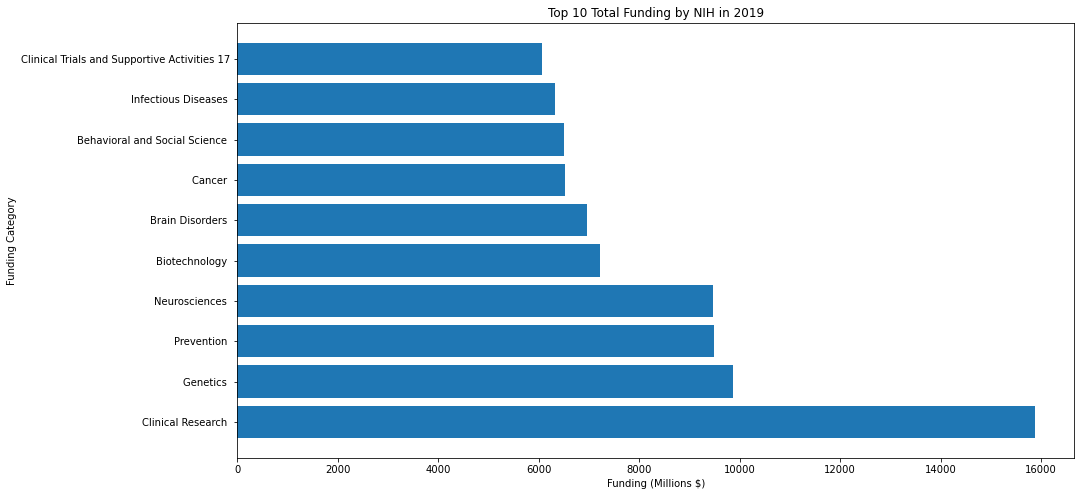

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))

# Graphing the first plot by using a bar chart
ax.barh(datatop10["research_category"],datatop10["2019"])
ax.set_title("Top 10 Total Funding by NIH in 2019")
ax.set_xlabel("Funding (Millions $)")
ax.set_ylabel("Funding Category")

# Saving the plot in figures folder
plt.savefig('figures/fig1a.png');

From the following graph, our team devised some interesting findings. It seems that Clinical Research was the most heavily invested in 2019, followed by Genetics with around and then tied in third place is Neurosciences and Prevention with around $9000 million. It's interesting to note that Clinical Research has almost two times the investment compared to the bottom of the top 10 list. 

However, our team was interested to see if this occurred every year. As such, we built a function that enables to graph a graph based on the inputted year found in our function.py file. This function can be seen and tested below. We include an example for 2016.

/home/jovyan/homework/hw07-group25/functiontools/functions.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



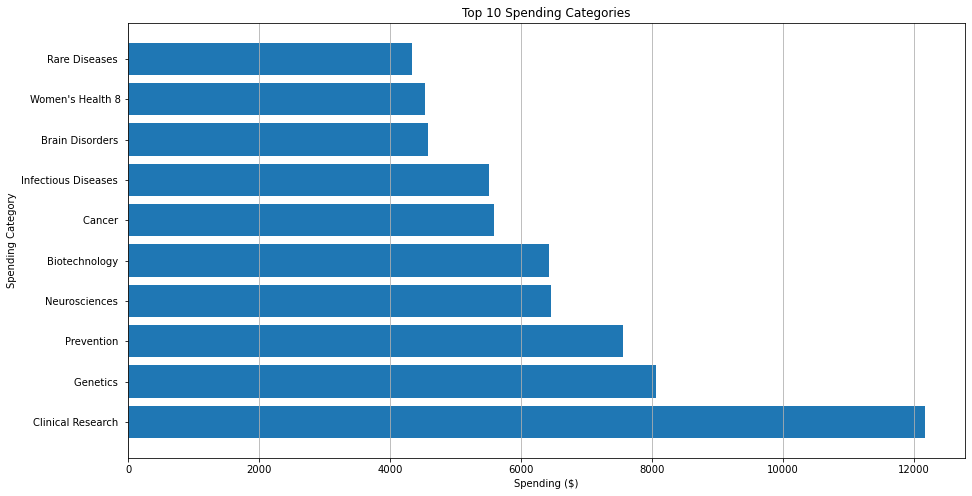

In [12]:
# Here we test out the graph for 2016
df = pd.read_hdf(h5File, "/data/cleaned_data")
fun.draw_barchart(df,'2016')

As we can see in the above graph, when we tested the year 2016, our group still came to similar conclusions. Clinical Research, Genetics, Prevention, and Neurosciences remainded top spenders even in 2016. Much like 2019, the Clinical Research spending remained almost double that of the bottom of the top 10, and Prevention, Genetics and Neurosciences remained closer together. However, there seems to be more variation at the bottom of the top 10. As time went on, NIH spending seemed to shift more towards Brain Disorders and Behavioral and Social Sciences. 

#### *2. Top 5 Funding Categories Over Time*

Next our team was curious: Has the funding for the top 5 funding categories in 2019 changed over time? For this second part, we tried to look for the top 5 funding categories over time. We only included the year of 2016 to 2020. We changed format of the dataset and created a dataframe of only the top 5 funding categories which were clinical research, genetics, prevention, neurosciences, and biotechnology. 

In [13]:
data_recent = df[["research_category", "2016", "2017", "2018", "2019", "2020"]]

# Filtering for different years 
for item in ["2016", "2017", "2018", "2019", "2020"]:
    data_recent[item] = fun.change_to_float(data_recent[item])

/tmp/ipykernel_1098/136155729.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
# Adjust the dataframes for the different top 5 category 
data_recent['total'] = data_recent['2016']+data_recent['2017']+data_recent['2018']+data_recent['2019']+data_recent['2020']
datatop5 = data_recent.sort_values("total", ascending=False)[:5]
datatop5 = datatop5[["research_category", "2016", "2017", "2018", "2019", "2020"]]
datatop5

/tmp/ipykernel_1098/1596165561.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,research_category,2016,2017,2018,2019,2020
60,Clinical Research,12176.0,12695.0,13870.0,15868.0,17610.0
114,Genetics,8070.0,8501.0,9105.0,9864.0,10544.0
225,Prevention,7566.0,8052.0,8757.0,9485.0,10482.0
188,Neurosciences,6460.0,7317.0,8224.0,9468.0,10122.0
33,Biotechnology,6433.0,6556.0,6923.0,7219.0,7767.0


In [15]:
# setting the index
datatop5 = datatop5.set_index('research_category').transpose().reset_index()
datatop5['index'] = (datatop5['index']).astype(int)
datatop5

research_category,index,Clinical Research,Genetics,Prevention,Neurosciences,Biotechnology
0,2016,12176.0,8070.0,7566.0,6460.0,6433.0
1,2017,12695.0,8501.0,8052.0,7317.0,6556.0
2,2018,13870.0,9105.0,8757.0,8224.0,6923.0
3,2019,15868.0,9864.0,9485.0,9468.0,7219.0
4,2020,17610.0,10544.0,10482.0,10122.0,7767.0


We then created a plot of the top 5 funding categories over time.

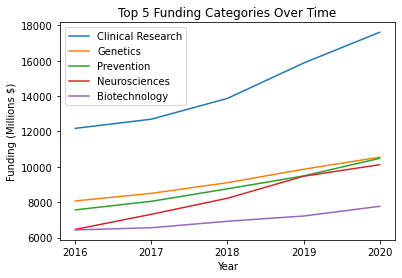

In [16]:
#Plotting the top 5 spending categories over time
plt.plot("index", 'Clinical Research ', data = datatop5, label = "Clinical Research");
plt.plot("index", 'Genetics ', data = datatop5, label = "Genetics");
plt.plot("index", 'Prevention ', data = datatop5, label = "Prevention");
plt.plot("index", 'Neurosciences ', data = datatop5, label = "Neurosciences");
plt.plot("index", 'Biotechnology ', data = datatop5, label = "Biotechnology");
plt.xticks(np.arange(2016, 2020+1, 1.0));
plt.xlabel("Year");
plt.ylabel("Funding (Millions $)");
plt.legend();
plt.title("Top 5 Funding Categories Over Time");

# Saving file under figures file
plt.savefig('figures/fig2.png')

From the plot above, we observed that the spending increased gradually over time. Clinical research had more spending compared to the other four categories. Note that here we did not include inflation. This could be the main reason why spending was increasing over time. To further study the trend, we might need to account for inflation in future analyses.

#### *3. Relationship Between Spending and Mortality*

Next our team, decided to look into the relationship between funding and mortality. We used data from 2019, as this was the year that both funding and US mortality rates were included in the dataset. We hypothesized that perhaps diseases or categories with higher mortality rates would have more funding. This led us to another insightful question: Is there a relationship between funding amounts, funding categories and mortality rates? We used cleaned data from 2019 and removed rows where there was no mortality data available (i.e. broad research areas like clinical research).

In [17]:
# Use pandas again to read data from the hdf5 file to the pandas DataFrame
df2019 = pd.read_hdf(h5File4, "/data/cleaned_data")

# select only the sample with no missing values for mortality or funding level
df2019 = df2019.dropna()

We then plotted mortality compared to funding in 2019, with a simple linear (OLS) regression. Since there was a high concentration of categories in the lower left corner of the plot, we used plotly to facilitate zooming in on the plot. Hovering over the points shows the funding category. 

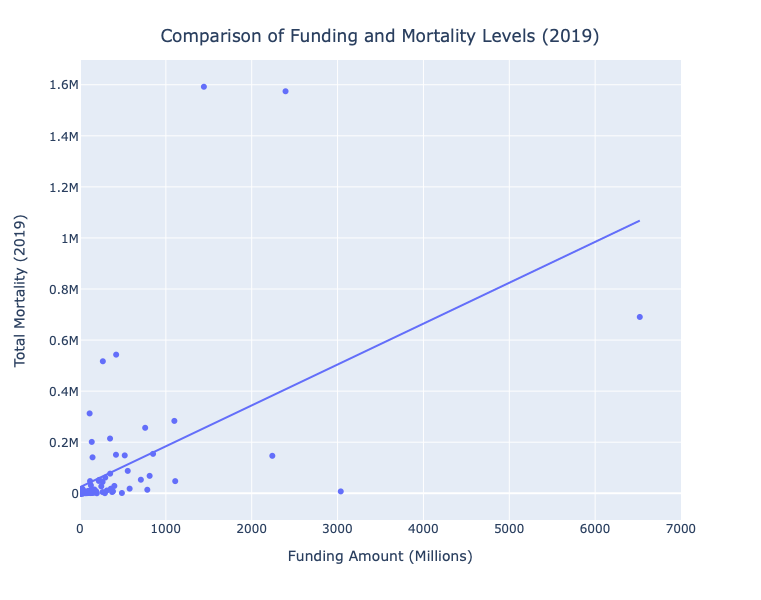

In [18]:
fig3a = px.scatter(df2019, x="2019", y="2019_US_Mortality_19", hover_data=['research_category'], 
                trendline="ols", 
                labels={
                     "2019_US_Mortality_19": "Total Mortality (2019)",
                     "research_category": "Research Category",
                     "2019": "Funding Amount (Millions)"
                 }, 
                width=800, height=600)


fig3a.update_layout(
    title={
        'text': "Comparison of Funding and Mortality Levels (2019)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig3a.update_layout(xaxis_range=[0,7000])

fig3a.write_image("figures/fig3a.png")

#fig3a.show()
py.iplot(fig3a, filename='fig3c')


Cardiovascular and heart disease both are outliers with about 1 million more deaths per each of these categories compared to the next highest categories for mortality. Funding is also higher for these categories compared to most others, but not proportionally compared to the high mortality seen. Seperate categories for coronary heart disease and hypertension also have high mortality but lower spendign compared to many other categories. Cancer in an outlier for high spending, with 6,520 million dollars going towards cancer research in 2019. The next highest category for funding is HIV/AIDS, which is 3,037 million per year -- which is disproportionate to the mortality of 7,150 people in 2019. 

This made us curious about what the highest and lowest ratios of funding to mortality were - so we calculated this as well. The plots below show this ratio (million spent per US death), for the highest 20 and lowest 20 ratios. One thing to note with this data is that only US mortality is included with this dataset. So for example, the NIH funded about 21.7 million on malaria research per US malaria death in 2019--but the global death toll is much higher and not accounted for here. Future research should incorporate global mortality rates. 

In [19]:
# calculate million per death
df2019['ratio'] = df2019['2019']/df2019['2019_US_Mortality_19']

# sort and select top 20 ratio values
df2019_t = df2019.sort_values("ratio", ascending=False)[:20]

# sort and select bottom 20 ratio values
df2019_b = df2019.sort_values("ratio", ascending=True)[:20]


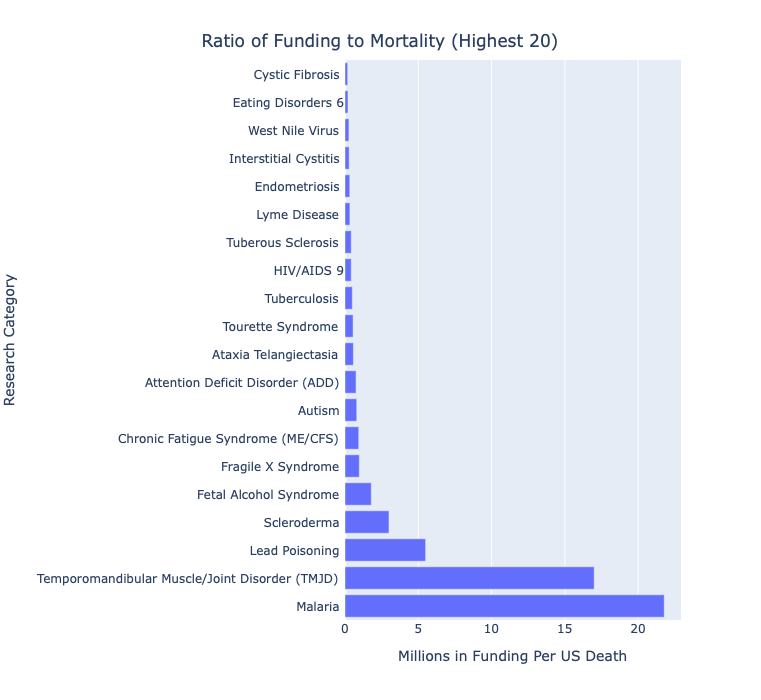

In [20]:
#Creating figure b
fig3b = px.bar(df2019_t, x='ratio', y='research_category', 
              width=800, height=700, 
             labels={
                     "ratio": "Millions in Funding Per US Death",
                     "research_category": "Research Category"
                 })

fig3b.update_layout(
    title={
        'text': "Ratio of Funding to Mortality (Highest 20)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig3b.write_image("figures/fig3b.png")

#fig3b.show()
py.iplot(fig3b, filename='fig3b')


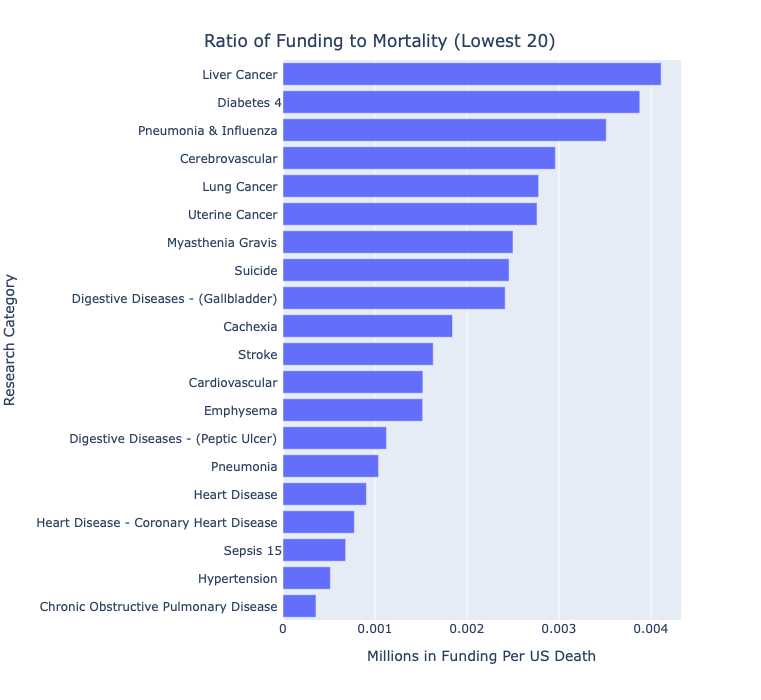

In [21]:
# Create figure c
fig3c = px.bar(df2019_b, x='ratio', y='research_category', 
              width=800, height=700, 
               labels={
                     "ratio": "Millions in Funding Per US Death",
                     "research_category": "Research Category"
                 })

fig3c.update_layout(
    title={
        'text': "Ratio of Funding to Mortality (Lowest 20)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})


fig3c.write_image("figures/fig3c.png")

#fig3c.show()
py.iplot(fig3c, filename='fig3c')

### Author Contributions

This section should indicate, for each team member, what they did in the project.

We all contributed equal amounts to the project and had great communication through email, text, and regular zoom meetings. Madeline Adee focused on the third part of the analysis and the introduction as well as the data cleaning, environment creation, and reproducibility critique of the original dataset. Nina Dickens worked on the first part of the data analysis, creating the functions python files, writing tests for functions, pyproj.toml, setup.py, and finally creating the JupyterBook. Meanwhile, Tina Li worked on the second part of the analysis, created our Makefile, README, and creating the Binder link. Although we were each assigned individual parts, ultimately we all helped each other throughout the process and everyone played some sort of role on every aspect of the project. 